In [1]:
# set conda
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local

# install psi4
!conda install -y psi4 python=3.7 -c psi4

# install rdkit
!conda install -q -y rdkit python=3.7 -c rdkit

# set path
import sys
sys.path.append("/usr/local/lib/python3.7/site-packages/")

# this command is needed to avoid "Loader" error.
!pip install distributed

--2022-04-24 10:09:39--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh [following]
--2022-04-24 10:09:39--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75660608 (72M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  72.16M  76.8MB/s    in 0.9s    

2022-04-24 10:09:40 (76.8 MB/s) - ‘Miniconda3-latest-Linu

In [2]:
# import Psi4
import psi4
# check Psi4 version
print(psi4.__version__)

1.5


In [3]:
!pip install py3Dmol

In [4]:
import py3Dmol
print(py3Dmol.__version__)

1.8.0


In [5]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem.rdDistGeom import ETKDGv3, EmbedMolecule
from rdkit.Chem.rdForceFieldHelpers import MMFFHasAllMoleculeParams, MMFFOptimizeMolecule
from rdkit.Chem.Draw import IPythonConsole
import psi4
import datetime
import time

In [6]:
# Molecules to enter (acetylsalicylic acid)
smiles = 'CC(=O)Oc1ccccc1C(=O)O'

In [7]:
# Decide the file name
t = datetime.datetime.fromtimestamp(time.time())
psi4.set_output_file("{}{}{}_{}{}_{}.log".format(t.year,
                                                t.month,
                                                t.day,
                                                t.hour,
                                                t.minute,
                                                smiles))

# Coarse 3D structure optimization by generating 3D structure from SMILES
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)
params = ETKDGv3()
params.randomSeed = 1
EmbedMolecule(mol, params)

# Structural optimization with MMFF (Merck Molecular Force Field)
MMFFOptimizeMolecule(mol)

# UFF (Universal Force Field) If you want to optimize the structure in a universal force field
# UFFOptimizeMolecule(mol)
conf = mol.GetConformer()

# Convert to a format that can be input to Psi4.
# Set charge and spin multiplicity (below is charge 0, spin multiplicity 1)
#mol_input = "0 1"

plus = smiles.count('+')
minus = smiles.count('-')
charge = plus - minus + 0 # total charge
multi = (charge%2) + 1 # 2S+1 = 2*((1/2)*(charge%2)) + 1 (low spin)
mol_input = str(charge) + " " + str(multi)

# Describe the coordinates of each atom in XYZ format
for atom in mol.GetAtoms():
    mol_input += "\n " + atom.GetSymbol() + " " + str(conf.GetAtomPosition(atom.GetIdx()).x)\
    + " " + str(conf.GetAtomPosition(atom.GetIdx()).y)\
    + " " + str(conf.GetAtomPosition(atom.GetIdx()).z)

In [8]:
molecule = psi4.geometry(mol_input)
print(molecule.save_string_xyz())
#The unit is angstrom

0 1
 C    3.032393635519    0.379987195250   -1.751175348891
 C    1.580820720598    0.235305231205   -1.410386269425
 O    0.661201119534    0.787730265615   -2.005641285461
 O    1.445422135807   -0.572978573247   -0.290168277060
 C    0.111854042570   -0.841353090510    0.036837503776
 C   -0.365196879081   -2.117335767560   -0.273999546926
 C   -1.668561071975   -2.472883636928    0.077163910815
 C   -2.486114679461   -1.565394571841    0.753790907850
 C   -2.003341296834   -0.296713229781    1.080881149099
 C   -0.703296715872    0.070349984438    0.715381505772
 C   -0.240599586325    1.409474075394    1.110570146291
 O   -0.090143146425    1.738673963415    2.273415213567
 O   -0.086616250508    2.240796670268    0.060519440752
 H    3.543272093972    0.936392737972   -0.961786379846
 H    3.483683064785   -0.607005236873   -1.880992125072
 H    3.129531556998    0.928268818827   -2.692493573424
 H    0.272835672079   -2.835748520749   -0.781687334207
 H   -2.045195496321   -3.4

In [10]:
def drawPsi4Geom(mol):
    xyz = mol.save_string_xyz_file() 
    view = py3Dmol.view(width=400, height=400)
    view.addModel(xyz, "xyz")
    view.setStyle({'stick':{}})
    view.zoomTo()
    return(view.show())

drawPsi4Geom(molecule)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [11]:
# Take a look at the calculation time
%%time

# Hardware side settings (CPU thread count and memory settings used for calculation)
psi4.set_num_threads(nthread=2)
psi4.set_memory("10GB")

# Set calculation method (functional) and basis function
level = "b3lyp/6-31G*"

# Perform structural optimization calculations
energy, wave_function = psi4.optimize(level, molecule=molecule, return_wfn=True)

Optimizer: Optimization complete!
CPU times: user 21min 37s, sys: 17.7 s, total: 21min 55s
Wall time: 11min 37s


In [12]:
#The unit is atomic unit (a.u. or Hartrees)
#Energy
print(round(energy,3),'a.u.')

-648.689 a.u.


In [13]:
# Display HOMO (Unit: au = Hartree)
LUMO_idx = wave_function.nalpha()
HOMO_idx = LUMO_idx - 1
homo = wave_function.epsilon_a_subset("AO", "ALL").np[HOMO_idx]
lumo = wave_function.epsilon_a_subset("AO", "ALL").np[LUMO_idx]
print('homo:',round(homo,5),' a.u.')
print('lumo:',round(lumo,5),' a.u.')

homo: -0.26021  a.u.
lumo: -0.0431  a.u.


In [14]:
psi4.oeprop(wave_function, 'MULLIKEN_CHARGES')
mulliken = np.array(wave_function.atomic_point_charges())
for i, atom in enumerate(mol.GetAtoms()):
    print(atom.GetSymbol(),round(mulliken[i],4))

C -0.527
C 0.6015
O -0.4757
O -0.5024
C 0.2961
C -0.147
C -0.1334
C -0.1206
C -0.1706
C 0.0274
C 0.5345
O -0.4395
O -0.5899
H 0.2051
H 0.1907
H 0.1951
H 0.1468
H 0.1476
H 0.1462
H 0.1705
H 0.4445


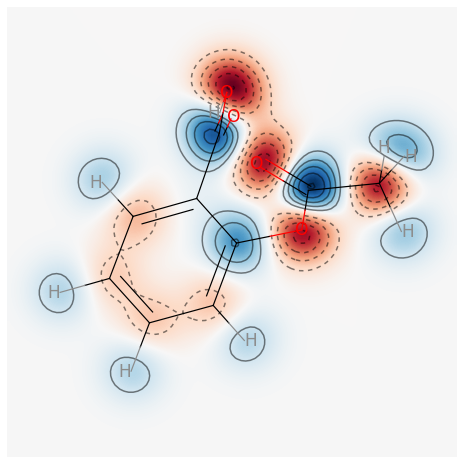

In [15]:
# similarity map
from rdkit.Chem.Draw import SimilarityMaps

fig = SimilarityMaps.GetSimilarityMapFromWeights(mol,
                                                 mulliken,
                                                 colorMap='RdBu')

In [16]:
psi4.oeprop(wave_function,'DIPOLE')
dipole_vec = psi4.variable('scf dipole')
dipole = np.sqrt(np.sum(dipole_vec ** 2))
print(f'{dipole:.3f} [D]')

2.035 [D]


In [17]:
Chem.MolToSmiles(mol)

'[H]OC(=O)c1c([H])c([H])c([H])c([H])c1OC(=O)C([H])([H])[H]'

In [18]:
from rdkit.Chem import MACCSkeys
# MACCS keys (166 bit)
maccs_fp = MACCSkeys.GenMACCSKeys(mol).ToBitString()
maccs_fp

'00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000001100000000010011000000001001100110100010101001011011110'

In [19]:
ds = list(MACCSkeys.GenMACCSKeys(mol).ToBitString())
print(ds)

['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '1', '0', '0', '1', '1', '0', '1', '0', '0', '0', '1', '0', '1', '0', '1', '0', '0', '1', '0', '1', '1', '0', '1', '1', '1', '1', '0']


In [20]:
maccs_array = []
for i in range(166):
  maccs_array.append(maccs_fp[i])
print(maccs_array)

['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '1', '0', '0', '1', '1', '0', '1', '0', '0', '0', '1', '0', '1', '0', '1', '0', '0', '1', '0', '1', '1', '0', '1', '1', '1', '1']


In [21]:
df = pd.DataFrame(ds)
df

,0
0,0
1,0
2,0
3,0
4,0
...,...
162,1
163,1
164,1
165,1
